In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# YOU SHOULD HAVE ALREADY COPIED OVER THE ASSIGNMENT FILES TO A FOLDER
# TITLED "cs-283-fall-21-assignments" ON YOUR GOOGLE DRIVE
%cd "/content/drive/My Drive/cs-283-fall-21-assignments/A7"

/content/drive/My Drive/cs-283-fall-21-assignments/A7


In [ ]:
# Download source files
!curl https://codeload.github.com/Harvard-CS283/pset-data/tar.gz/main | \
    tar -xz --strip=2 pset-data-main/pset7

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31.0M    0 31.0M    0     0  21.2M      0 --:--:--  0:00:01 --:--:-- 21.2M


In [3]:
# Import any required libraries here
import cv2                # OpenCV
import numpy as np        # numpy
import pickle

from matplotlib.colors import LightSource
from matplotlib import cm
import scipy.linalg

# Use this line to make matplotlib plot inline (only need to call it once when importing matplotlib)
# For 3D plotting, it can be helpful to call %matplotlib notebook, but note that if you want to switch back to inline,
# you'll need to restart the kernel
%matplotlib inline

import matplotlib.pyplot as plt
# Modify this line to adjust the displayed plot size. You can also call
# it with different parameters before specific plots.
plt.rcParams['figure.figsize'] = [10, 10]

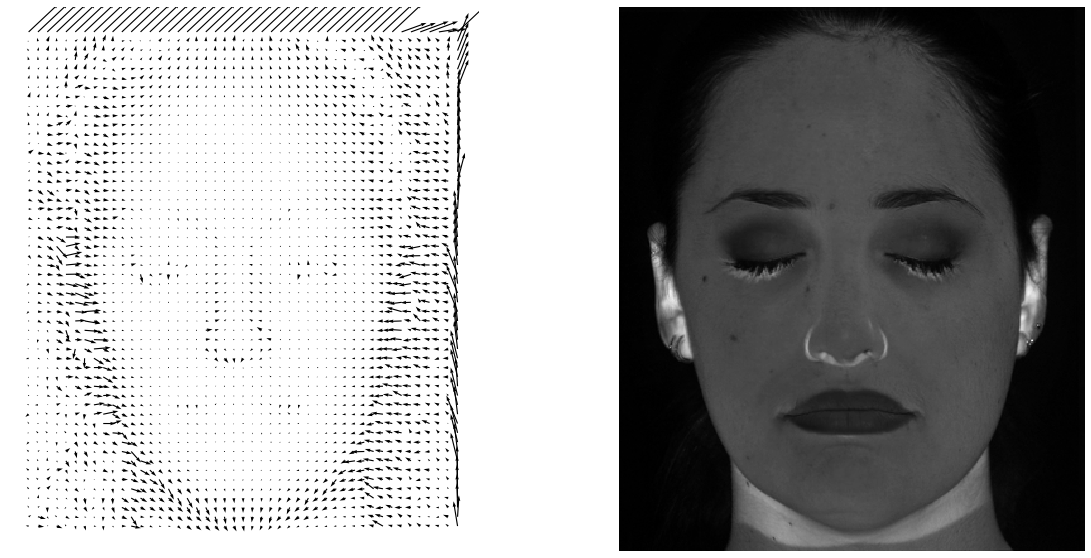

In [11]:
# load images into images list
images = []

# load images as intensity matrix at each pixel based on 7 images
imstack = []
for i in range(1, 8):
  imstack.append((cv2.imread(f'./data/face_0{i}.tif', cv2.IMREAD_GRAYSCALE)).flatten())
imstack = np.vstack(imstack)

# get image dimesion
im = cv2.imread('./data/face_01.tif', cv2.IMREAD_GRAYSCALE)
x, y = im.shape[1], im.shape[0]

# load light source vector S
S = pickle.load(open('./data/sources.pickle', 'rb'))['S']

# use lambertian photometric stereo to calculate psudo normal
N = np.linalg.pinv(S).dot(imstack).T.reshape(y,x,3)

# vect_x is an HxW array of x-components
vect_x = N[:,:,0] / N[:, :, 2]

# vect_y is an HxW array of y-components
vetc_y = N[:,:,1] / N[:, :, 2]

# calculate albedo
rho = np.sqrt(N[:,:,0]**2 + N[:,:,1]**2 + N[:,:,2]**2)

n = 8        # set step

# plot normals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20,10])
ax1.quiver(vect_x[::n, ::n], vetc_y[::n, ::n],cmap='gray')
ax1.invert_yaxis()
ax1.axis('image')
ax1.axis('off')

ax2.imshow(rho, cmap='gray', interpolation='nearest', vmin=rho.min(), vmax=rho.max())
ax2.axis('image')
ax2.axis('off')

plt.show()

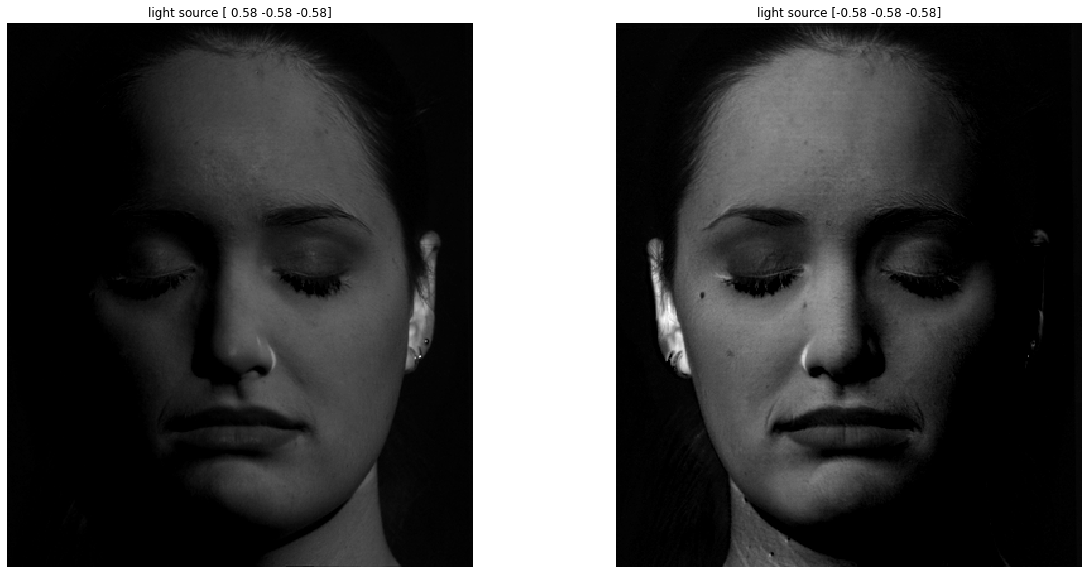

In [12]:
# light source direcions
light1 = np.array([0.58, -0.58, -0.58], np.float64)
light2 = np.array([-0.58, -0.58, -0.58], np.float64)

# compute the I value using I = b.T * l
I1 = light1.dot(N.flatten().reshape(-1, 3).T)
I1[np.where(I1 < 0)] = 0
I1 = I1.reshape(y, x)
I2 = light2.dot(N.flatten().reshape(-1, 3).T)
I2[np.where(I2 < 0)] = 0
I2 = I2.reshape(y, x)

# plot images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 10])
ax1.imshow(I1, cmap='gray', interpolation='nearest', vmin=I1.min(), vmax=I1.max())
ax1.axis('image')
ax1.set_title(f'light source {light1}', fontsize = 12)
ax1.axis('off')
ax2.imshow(I2, cmap='gray', interpolation='nearest', vmin=I2.min(), vmax=I2.max())
ax2.axis('image')
ax2.set_title(f'light source {light2}', fontsize = 12)
ax2.axis('off')
plt.show()

**d.** The function <tt> integrate_frankot()</tt> below can be used to recover a surface $z(x,y)$ from your
surface normals $\hat{n}(x,y)$. Run the two cells below to generate and display your surface, and then modify the second cell to include two views of your surface.

In [13]:
def integrate_frankot(N):
    
    """
    integrate_frankot(N) takes an PxQx3 field of normal vectors (the third
    dimension is [x y z]) and returns a PxQ array corresponding to the
    depth of the surface, with the mean depth equal to zero.
    
    Reference: Frankot, R. and Chellapa, R. (1988) "A Method for Enforcing
    Integrability in Shape from Shading Algorithms."  IEEE Trans. Pattern
    Anal. Mach. Intell. 10(4):439-451.

    Args:
        N: PxQx3 field of normal vectors

    Returns:
        PxQ array corresponding to the depth of the surface, with the mean depth equal to zero

    Todd Zickler, November 2001; updated for CS283 October 2019.

    """

    h, w = N[:, :, 0].shape

    # complain if P or Q are too big
    if (h > 512) |  (w > 512):
        print('Input array too big.  Choose a smaller window.')

    # pad the array to 512x512
    nrows = 2 ** 9
    ncols = 2 ** 9
    
    # get surface slopes from normals; ignore points where normal is [0 0 0]
    x_sample = 1
    y_sample = 1
    zx = -x_sample * (np.sum(N, 2) != 0) * N[:, :, 0] / (N[:, :, 2] + (N[:, :, 2] == 0))
    zy = -y_sample * (np.sum(N, 2) != 0) * N[:, :, 1] / (N[:, :, 2] + (N[:, :, 2] == 0))

    Zx_sq = np.fft.fft2(zx, s=[nrows, ncols])
    Zy_sq = np.fft.fft2(zy, s=[nrows, ncols])
    h2 = nrows
    w2 = ncols
    
    Zx = Zx_sq.flatten('C')
    Zy = Zy_sq.flatten('C')
    
    # compute repeated frequency vectors (See Chellapa paper)
    h2_vec = np.expand_dims(np.concatenate((np.arange(0, h2/2 + 1),np.arange(-h2/2+1, 0))), 1)
    w2_vec = np.expand_dims(np.concatenate((np.arange(0, w2/2 + 1),np.arange(-w2/2+1, 0))), 1)
    
    Wx = np.squeeze(np.tile(2 * np.pi / h2 * h2_vec, [w2, 1]))
    Wy = np.squeeze(np.kron(2 * np.pi / w2 * w2_vec, np.ones((h2, 1))))
    
    # compute transform of least squares closest integrable surface
    Wx[0] = 1
    Wy[0] = 1
    # remove first column because it's all zeros (then add C(0)=0)
    C = (-1j * Wx * Zx - 1j * Wy * Zy) / (np.power(Wx, 2) + np.power(Wy, 2))
  
    # set DC component of C
    C[0] = 0
    
    # invert transform to get depth of integrable surface
    Z = np.real(np.fft.ifft2(np.reshape(C, [h2, w2], 'C')))
    
    # crop Z to original input shape
    Z = Z[:h, :w]
    
    return Z

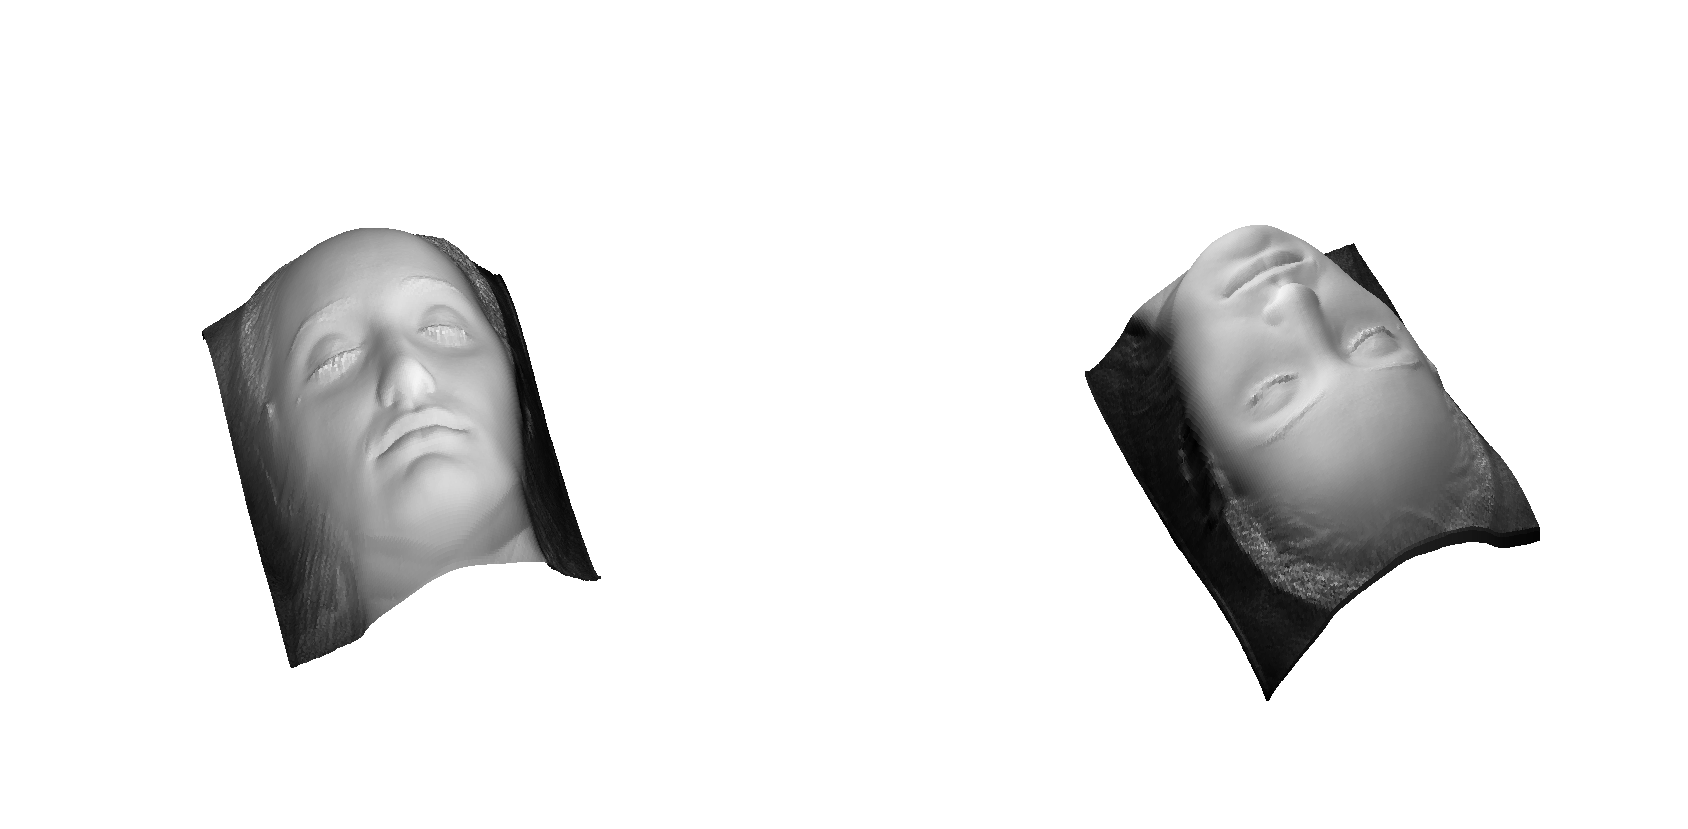

In [37]:
Z = integrate_frankot(N)
h, w = N[:, :, 0].shape

# Define a meshgrid of X and Y coordinates
X,Y = np.meshgrid(np.arange(w), np.arange(h))

# Create a figure and define its axes
fig = plt.figure(figsize=(30, 15))
ax1 = fig.add_subplot(1,2,1, projection='3d')
ax1.axis('off')
ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.axis('off')

# Define the viewing angle
ax1.view_init(elev=240, azim=-75)
ax2.view_init(elev=240, azim=120)

# Define a light source direction
ls = LightSource(azdeg=260, altdeg=125)
surf_illum = ls.shade(Z, cmap=cm.gist_yarg)

# Shade data, creating an rgb array.
surf1 = ax1.plot_surface(X, Y, Z, rstride=2, cstride=2, linewidth=0,
                       antialiased=False, facecolors=surf_illum)

surf2 = ax2.plot_surface(X, Y, Z, rstride=2, cstride=2, linewidth=0,
                       antialiased=False, facecolors=surf_illum)

# Create cubic bounding box to simulate equal aspect ratio
# https://stackoverflow.com/questions/13685386/matplotlib-equal-unit-length-with-equal-aspect-ratio-z-axis-is-not-equal-to
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z.max()+Z.min())

for xb, yb, zb in zip(Xb, Yb, Zb):
    ax1.plot([xb], [yb], [zb], 'w')
    ax2.plot([xb], [yb], [zb], 'w')

# Show the plot
plt.show()